# Train Agent

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from collections import namedtuple, Counter

from environment import Santorini
from qnetwork import *
from replay_memory import *
from agent import Agent

## Environment

In [2]:
env = Santorini()
env.print_board()

Buildings:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0  0 -1  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  2]
 [ 0  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 22  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]


In [3]:
env.step(27)

(array([ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0,  0,
        21, 18, 14, 18]), -0.001, False, 1)

In [4]:
legals = env.legal_moves()
actions = np.array([19,12,1])

In [5]:
env.print_board()

Buildings:
 [[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0 -1  0  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  2]
 [ 0  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 21  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]


In [6]:
p1_action = env.atoi[(-1,'x','d')]; p1_action

52

In [7]:
env.step(p1_action), env.print_board()

Buildings:
 [[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0 -1  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  2]
 [ 1  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]


((array([ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0, -2, -1,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,
         20, 18, 14, 18]), -0.001, False, -1), None)

In [8]:
p2_action = env.atoi[(-1,'d','d')]; p2_action

36

In [9]:
env.step(p2_action)

(array([ 1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  2,  1,  0,  0,  0,  0,  0,  0, -2,  0,  0,  0,
        19, 18, 14, 18]), -0.001, False, 1)

In [10]:
env.action_dim, env.state_dim_flat

(128, 55)

## Agent

In [11]:
#memories
mem1 = PrioritizedMemory(capacity = 1000)
mem2 = PrioritizedMemory(capacity = 1000)
#agents
a1 = Agent(state_size = env.state_dim_flat, action_size = env.action_dim, replay_memory = mem1, seed = 1412,
          lr = 1e-3 / 4, bs = 64, nb_hidden = 128,
          gamma=0.99, tau= 1/100, update_interval = 5)
a2 = Agent(state_size = env.state_dim_flat, action_size = env.action_dim, replay_memory = mem2, seed = 1412,
          lr = 1e-3 / 4, bs = 64, nb_hidden = 128,
          gamma=0.99, tau= 1/100, update_interval = 5)

In [49]:
winners = []
timesteps = []
game_records = []

env = Santorini()
for i in trange(10000):
    state = env.reset()
    timestep = 0
    game_record = [env.board]
    while True:
        #select action
        if i % 2 == 0: 
            actions = a1.act(state,i,return_list=True)
        else:
            actions = a2.act(state,i,return_list=True)
            
        #check legality
        legal_moves = env.legal_moves()
        for a in actions:
            if a in legal_moves:
                action = a
                break
        
        #step action
        next_state,reward,done,next_player = env.step(action)
        game_record.append(env.board)
        timestep+=1
            
        #step agent; store transition and train
        if i % 2 == 0: 
            a1.step(state,action,reward,next_state,done,i)
        else:
            a2.step(state,action,reward,next_state,done,i)
            
        #break if done
        if done: break
            
    #record
    winners.append(-next_player)
    timesteps.append(timestep)
    game_records.append(game_record)
    #print(f'Player {current_player} wins in {timestep} turns')

  0%|          | 0/1 [00:00<?, ?it/s]/home/charin/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:54: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


In [50]:
Counter(winners)

Counter({-1: 1})

(31.0, 31, 31)

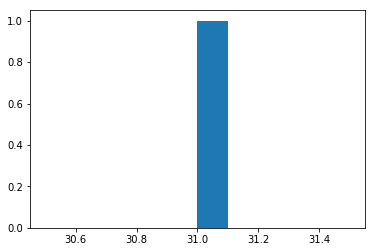

In [51]:
plt.hist(timesteps)
np.mean(timesteps),np.min(timesteps),np.max(timesteps)

In [57]:
game_records[-1][-1]

array([[[ 4,  4,  4,  4,  3],
        [ 3,  4,  2,  3,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  2],
        [ 0,  0,  0,  0,  0],
        [ 0,  0, -2,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0, 13,  0,  0,  0],
        [ 0,  0,  9,  0,  0],
        [ 0,  0,  0,  6,  0],
        [ 0,  0,  0,  0, 13]]])

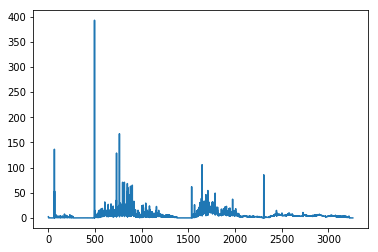

In [29]:
plt.plot(a1.losses)

In [61]:
fname = 'half_rainbow.m'
#save
torch.save(a1.qnetwork_local.state_dict(), fname)
#load
a1.qnetwork_local.load_state_dict(torch.load(fname))
a1.qnetwork_target.load_state_dict(torch.load(fname))

## Versus Human

In [62]:
env = Santorini()
env.print_board()

Buildings:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0  0 -1  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  2]
 [ 0  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 22  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]


### Human's Turn

In [83]:
human_key = (-1,'d','a')
human_action = env.atoi[human_key]
env.current_player, human_key, human_action

(-1, (-1, 'd', 'a'), 35)

In [84]:
env.step(human_action)
env.print_board()

Buildings:
 [[3 3 0 0 0]
 [0 0 0 0 0]
 [3 0 0 0 0]
 [0 2 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0 -1  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  2]
 [ 0  1  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 18  0  0  0]
 [ 0  0 14  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 18]]


### Agent's Turn

In [85]:
actions = a1.act(state,1000,return_list=True)
#check legality
legal_moves = env.legal_moves()
for a in actions:
    if a in legal_moves:
        agent_action = a
        break
env.current_player, env.itoa[agent_action], agent_action

(1, (-1, 'q', 'c'), 7)

In [86]:
env.step(agent_action)
env.print_board()

Buildings:
 [[3 3 0 0 0]
 [0 0 0 0 0]
 [3 0 0 0 0]
 [0 3 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0 -1  0  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  2]
 [ 0  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 18  0  0  0]
 [ 0  0 14  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0 18]]
